In [1]:
import sys
import os
from IPython.core.display import display, HTML

"""
On Windows, sometimes, some cuda libraries does not work very well. One needs to add the cuda path mannually.
The following line is an example.
"""
#os.environ['NUMBAPRO_CUDALIB']=r"C:\Users\hyli\Anaconda3\envs\python36\Library\bin"
os.environ['NUMBAPRO_CUDALIB']=r"C:\Users\hyli93\Miniconda3\envs\python36\Library\bin"

"""
Because I have not realised this package. To use this package, one can not simply install with pip.
Instead, one needs to clone from the repo and append the path to this repo to the system path variable.
"""
sys.path.append('C:/Users/hyli93/Documents/GitHub/Phasing/')

"""
This line is totally optional. It only changes the cell width.
"""
display(HTML("<style>.container { width:95% !important; }</style>"))

# Import some other necessary packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import PhaseTool   # This is the name of this package
import copy
from scipy import ndimage

# Create a smooth object

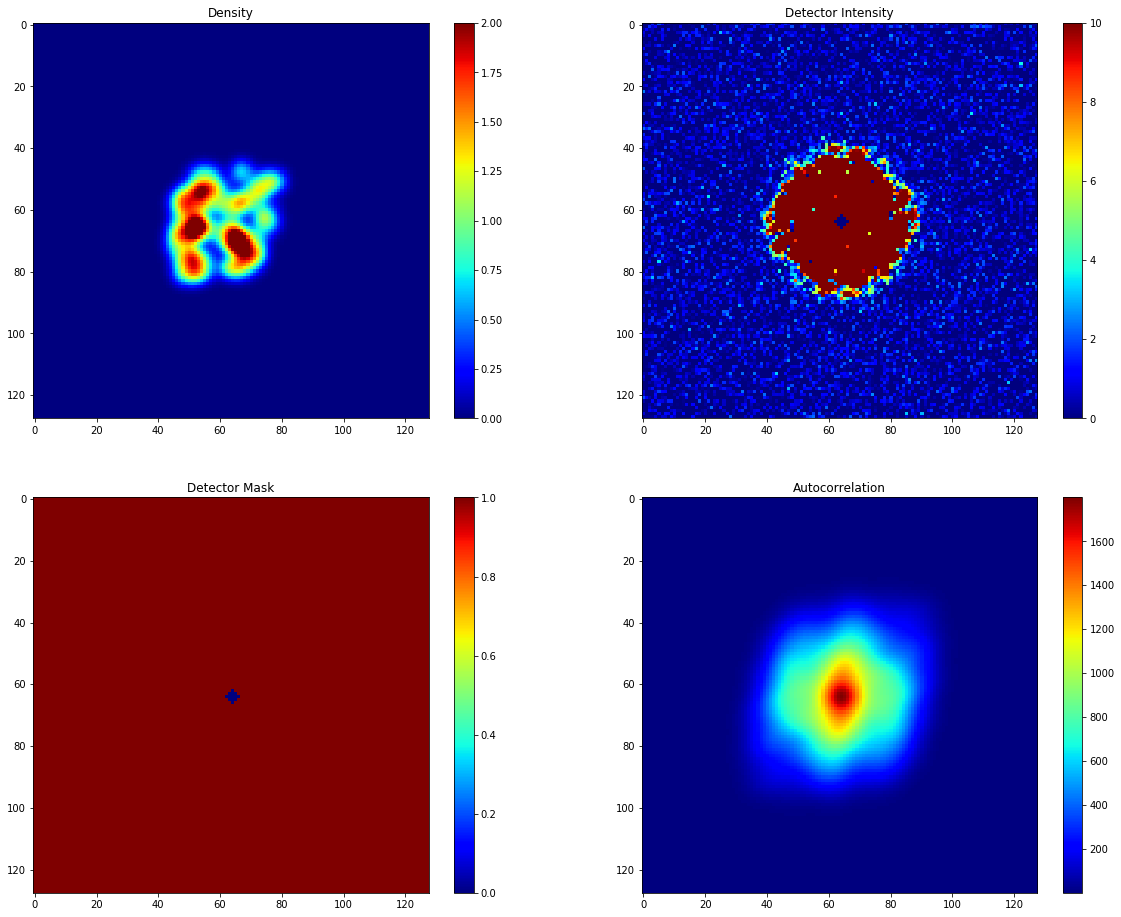

In [2]:
sample = PhaseTool.util.SmoothSample(support_length=32, space_length=128, obj_num=34)


############################################################################################################
#  Show sample information
############################################################################################################
# Set up the canvas
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(16)
fig.set_figwidth(20)

im = axes[0,0].imshow(sample.density, vmin=0, vmax=2, cmap='jet')
fig.colorbar(im, ax=axes[0,0])
axes[0,0].set_title("Density")

im = axes[0,1].imshow(sample.det_noisy_intensity, vmax=10, cmap='jet')
fig.colorbar(im, ax=axes[0,1])
axes[0,1].set_title("Detector Intensity")

im = axes[1,0].imshow(sample.detector_mask,vmin=0, vmax=1, cmap='jet')
fig.colorbar(im, ax=axes[1,0])
axes[1,0].set_title("Detector Mask")

im = axes[1,1].imshow(PhaseTool.util.get_autocorrelation(sample.intensity), vmin=0.4 ,cmap='jet')
fig.colorbar(im, ax=axes[1,1])
axes[1,1].set_title("Autocorrelation")

# Show the canvas
plt.show()  

# Test Step 1: Try some RAAR

In [3]:
from scipy.interpolate import LinearNDInterpolator


def fill_detector_gap(magnitude, magnitude_mask):
    """
    Previously, I think radial value is a good choice to fill the gaps. Now, I do not think so.
    I will simply use "from scipy.interpolate import RegularGridInterpolator" to handle this.
    It is basically, a N-d linear interpolation.

    :param magnitude:
    :param magnitude_mask:
    :return:
    """

    # Step 1: Check if there is any gap:
    if np.all(magnitude_mask):

        print("There is no gap on the detector. Use the original magnitude.")
        return magnitude

    else:
        # Step 2: Begin the interpolation
        # Create coordinate mesh grid
        coordiantes = np.meshgrid(*(np.arange(x, dtype=np.int64) for x in magnitude.shape))

        # Apply the masks to extract the valid points
        valid_points = [x[magnitude_mask] for x in coordiantes]
        valid_points = np.transpose(np.stack(valid_points))
        valid_values = magnitude[magnitude_mask]

        # Apply the masks to find out where to interpolate
        mask_not = np.logical_not(magnitude_mask)
        unknown_points_list = [x[mask_not] for x in coordiantes]
        unknown_points = np.transpose(np.stack(unknown_points_list))

        # Create an interpolation object
        my_interpolating_function = LinearNDInterpolator(valid_points, valid_values)

        # Carry out the interpolation
        interpolate_value = my_interpolating_function(unknown_points)

        # Fill pixels inside the gaps with the interpolated values
        mag_copy = np.copy(magnitude)
        mag_copy[unknown_points_list] = interpolate_value

        return mag_copy


def get_support_from_autocorrelation(magnitude, magnitude_mask,
                                     threshold=0.04,
                                     gaussian_filter=True,
                                     gaussian_sigma=1.,
                                     flag_fill_detector_gap=False):
    """

    :param magnitude:
    :param magnitude_mask:
    :param threshold:
    :param gaussian_filter:
    :param gaussian_sigma:
    :param flag_fill_detector_gap:
    :return:
    """

    # Step 1. Check if I need to fix those gaps.
    if flag_fill_detector_gap:

        # Create a variable to handle both case at the same time
        data_tmp = fill_detector_gap(magnitude=magnitude,
                                     magnitude_mask=magnitude_mask)
    else:
        data_tmp = magnitude

    # Step 2. Get the correlation
    autocorrelation = np.abs(np.fft.ifftn(np.square(data_tmp)))

    if gaussian_filter:
        ndimage.gaussian_filter(input=autocorrelation,
                                sigma=gaussian_sigma,
                                output=autocorrelation)

    # Step 3. Get the threshold and get the support.

    # Set all the pixels with values lower than the threshold to be zero.
    # Notice that here, the true threshold (threshold_t) is low + threshold * span
    low = np.min(autocorrelation)

    print(low)

    span = np.max(autocorrelation) - low
    print(span)

    threshold_t = low + threshold * span

    print("The true threshold is {}".format(threshold_t))

    support_holder = np.ones_like(magnitude_mask, dtype=np.bool)
    support_holder[autocorrelation <= threshold_t] = False

    return support_holder

In [4]:
get_support_from_autocorrelation(sample.det_noisy_magnitude, magnitude_mask=sample.detector_mask, flag_fill_detector_gap=False)

1.007759755831563
845.1053800211193
The true threshold is 34.81197495667634


array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [5]:
# Step 1: Create a object
alter_proj = PhaseTool.AlterProj.CpuAlterProj()

# Step 2: Initialize the object with the data
alter_proj.initialize_easy(magnitude=sample.det_noisy_magnitude ,
                           magnitude_mask=sample.detector_mask,
                           full_initialization=False)
print("hahaha")
# Step 3: Set initial guess
alter_proj.use_auto_support(threshold=0.04, gaussian_filter=True,sigma=1.0, fill_detector_gap=True)

alter_proj.derive_initial_density(fill_detector_gap=True, method="Random")
    
alter_proj.set_algorithm(alg_name="RAAR")
alter_proj.set_beta_and_iter_num(beta=0.87,
                                 iter_num=1200,
                                 decay=True, 
                                 decay_rate=30)



The center of the diffraction is :
[64. 64.]
hahaha
The true threshold is 52.24041151474761


Exception: There are some nan values in the new array.

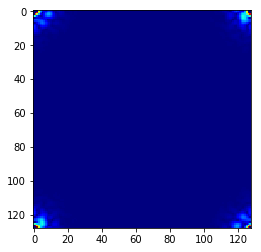

In [13]:
plt.imshow(alter_proj.magnitude, cmap='jet')

In [4]:
# Step 4: Execute the algorithm of RAAR with 200 Iterations:
alter_proj.execute_algorithm()

Using algorithm RAAR
Finishes self-consistency check.


C:/Users/hyli93/Documents/GitHub/Phasing\PhaseTool\CpuUtil.py:89: RuntimeWarning: invalid value encountered in greater
  np.greater(support_t[support], 0, out=support_m[support])


# Visualization Section

The relative difference is 0.5594663611769115%


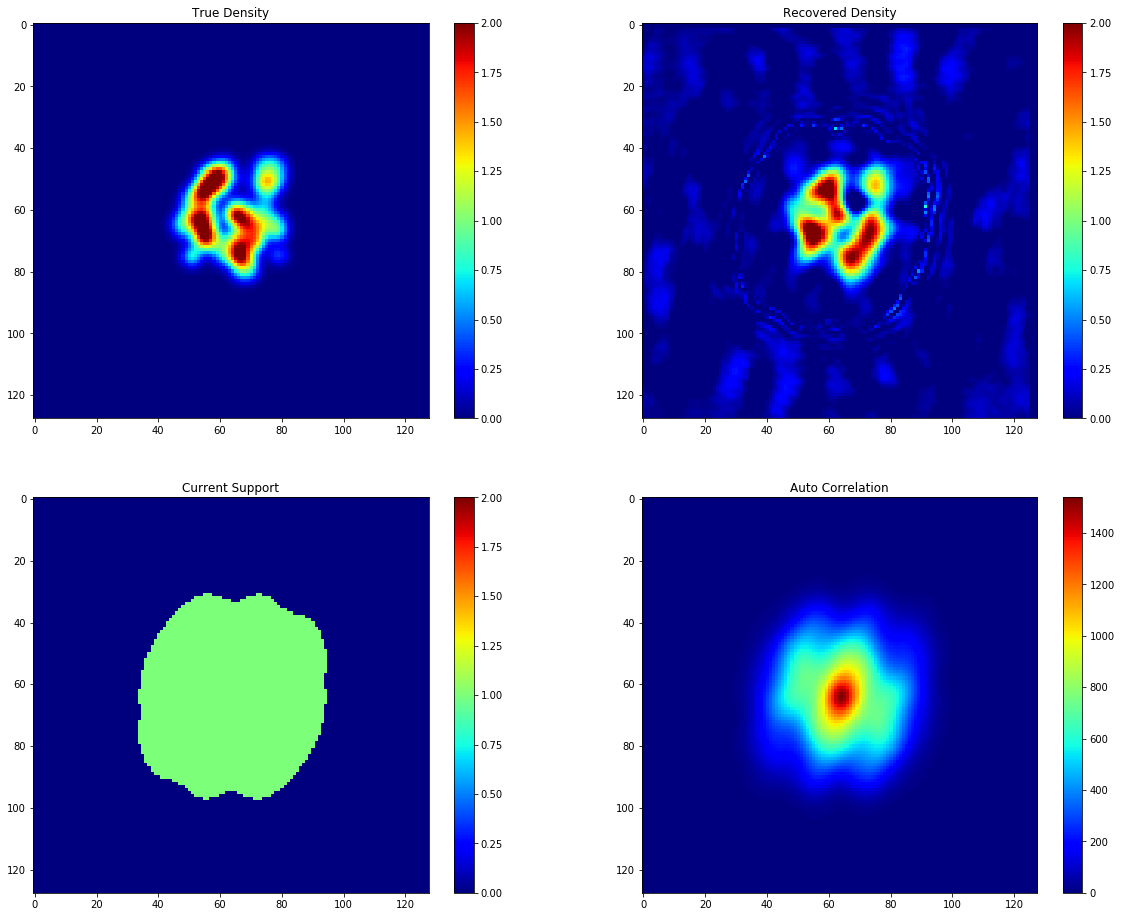

In [5]:
# Set up the canvas anc compare result
recover, _, _ = PhaseTool.util.resolve_trivial_ambiguity(array=np.fft.ifftshift(alter_proj.data_dict['density']), reference_array=sample.density)

print("The relative difference is {}%".format(np.sqrt(np.sum(np.square(recover - sample.density))) / np.sqrt(np.sum(np.square(sample.density)))))

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(16)
fig.set_figwidth(20)

im = axes[0,0].imshow(sample.density, vmax=2, cmap='jet')
fig.colorbar(im, ax=axes[0,0])
axes[0,0].set_title("True Density")

im = axes[0,1].imshow(recover, vmin=0, vmax=2, cmap='jet')
fig.colorbar(im, ax=axes[0,1])
axes[0,1].set_title("Recovered Density")

im = axes[1,0].imshow(np.abs(np.fft.ifftshift(alter_proj.data_dict['support'])), vmax=2, cmap='jet')
fig.colorbar(im, ax=axes[1,0])
axes[1,0].set_title("Current Support")

im = axes[1,1].imshow(sample.autocorrelation,cmap='jet')
fig.colorbar(im, ax=axes[1,1])
axes[1,1].set_title("Auto Correlation")

# Show the canvas
plt.show()  

# Test step 2: Try some ER

In [6]:
alter_proj.set_algorithm(alg_name="ER")
alter_proj.set_beta_and_iter_num(iter_num=500)

Since the argument beta is not specified, the arguments decay and decay_rate are ignored.


In [7]:
alter_proj.execute_algorithm()

Using algorithm ER
Finishes self-consistency check.


# Visualization Section

The relative difference is 0.4722947030463612%


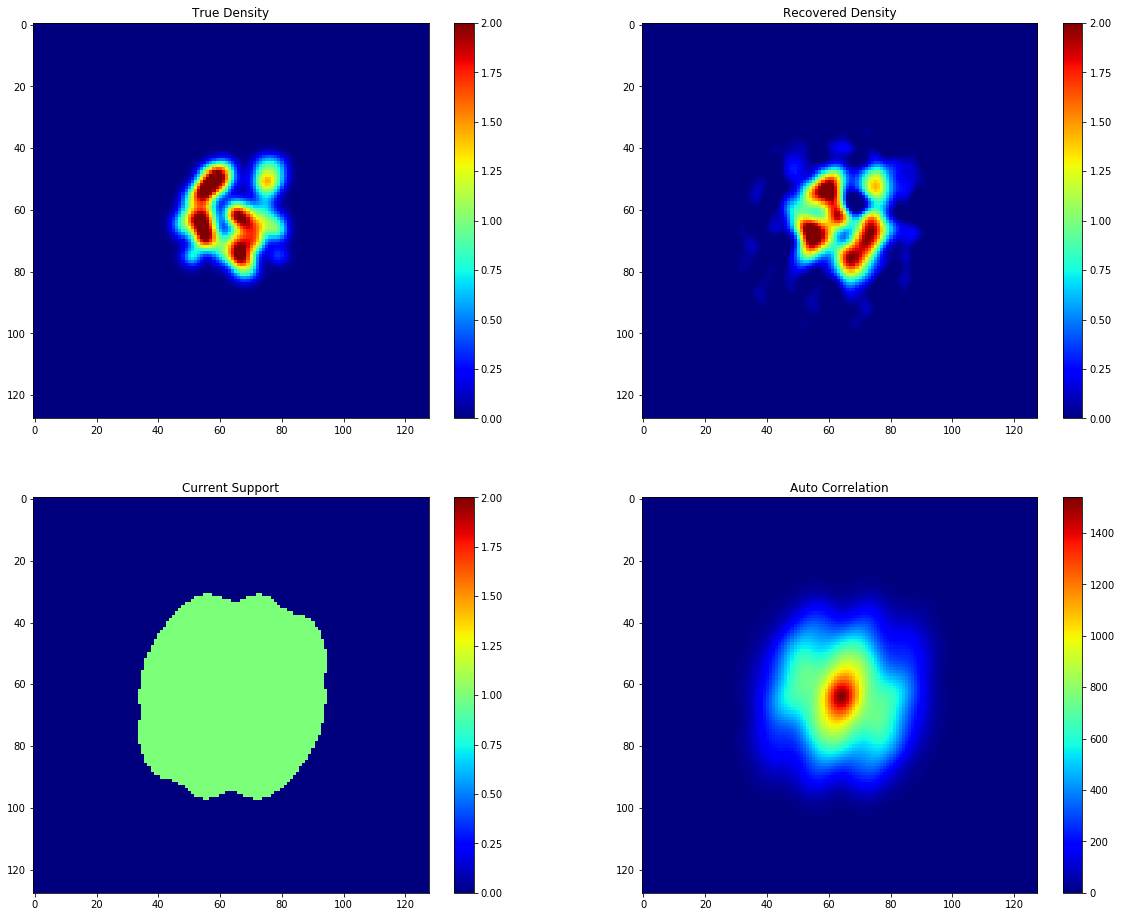

In [8]:
# Set up the canvas anc compare result
recover, _, _ = PhaseTool.util.resolve_trivial_ambiguity(array=np.fft.ifftshift(alter_proj.data_dict['density']), reference_array=sample.density)

print("The relative difference is {}%".format(np.sqrt(np.sum(np.square(recover - sample.density))) / np.sqrt(np.sum(np.square(sample.density)))))

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(16)
fig.set_figwidth(20)

im = axes[0,0].imshow(sample.density, vmax=2, cmap='jet')
fig.colorbar(im, ax=axes[0,0])
axes[0,0].set_title("True Density")

im = axes[0,1].imshow(recover, vmin=0, vmax=2, cmap='jet')
fig.colorbar(im, ax=axes[0,1])
axes[0,1].set_title("Recovered Density")

im = axes[1,0].imshow(np.abs(np.fft.ifftshift(alter_proj.data_dict['support'])), vmax=2, cmap='jet')
fig.colorbar(im, ax=axes[1,0])
axes[1,0].set_title("Current Support")

im = axes[1,1].imshow(sample.autocorrelation,cmap='jet')
fig.colorbar(im, ax=axes[1,1])
axes[1,1].set_title("Auto Correlation")

# Show the canvas
plt.show()  

# Test Step 3: Try some RAAR

In [9]:
alter_proj.set_algorithm(alg_name="RAAR")
alter_proj.set_beta_and_iter_num(beta=0.87,
                                 iter_num=1200,
                                 decay=True, 
                                 decay_rate=30)


The user uses a constant value for the beta value. This valuesbeta = 0.87
This values is recognized as the initial beta value for a list of decaying beta values. The length of this list is the iter_num valuewhich is 1200


In [10]:
alter_proj.execute_algorithm()

Using algorithm RAAR
Finishes self-consistency check.


# Visualization Section

The relative difference is 0.5323363704599562%


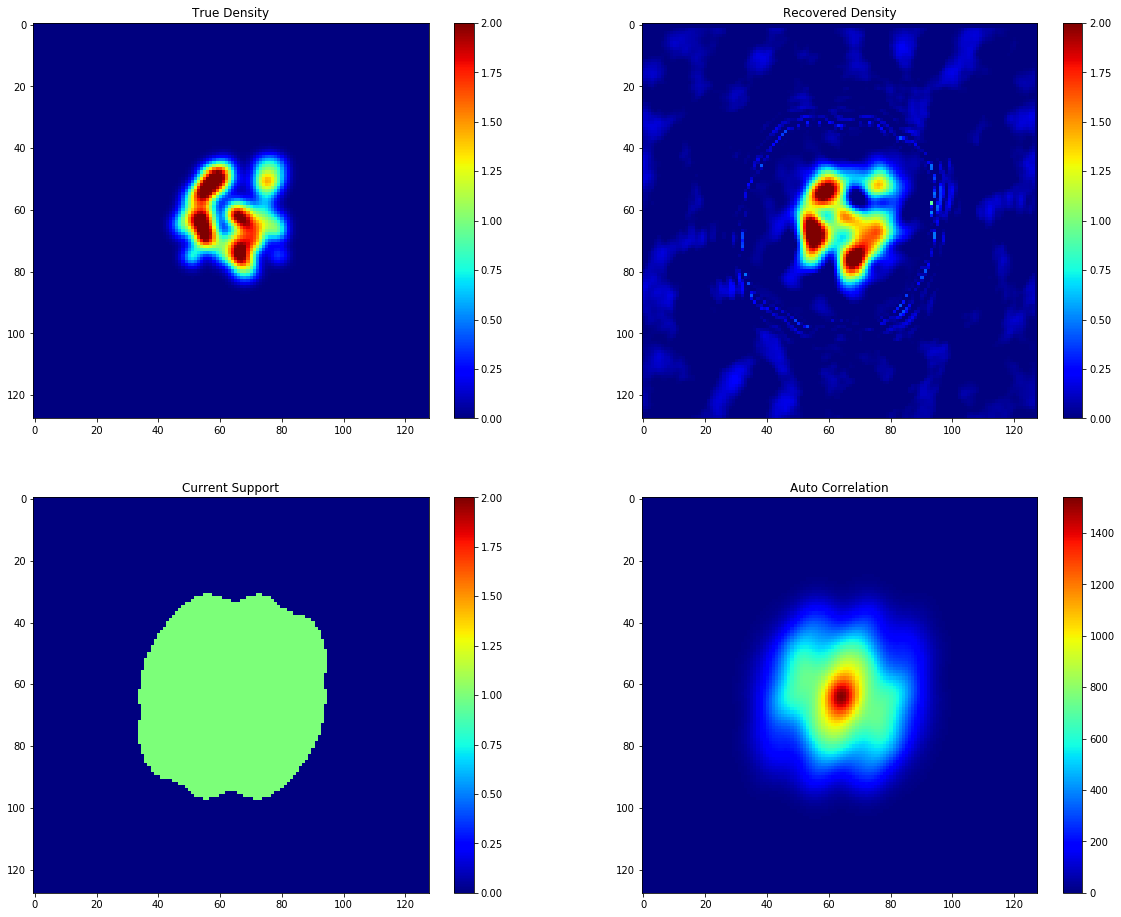

In [11]:
# Set up the canvas anc compare result
recover, _, _ = PhaseTool.util.resolve_trivial_ambiguity(array=np.fft.ifftshift(alter_proj.data_dict['density']), reference_array=sample.density)

print("The relative difference is {}%".format(np.sqrt(np.sum(np.square(recover - sample.density))) / np.sqrt(np.sum(np.square(sample.density)))))

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(16)
fig.set_figwidth(20)

im = axes[0,0].imshow(sample.density, vmax=2, cmap='jet')
fig.colorbar(im, ax=axes[0,0])
axes[0,0].set_title("True Density")

im = axes[0,1].imshow(recover, vmin=0, vmax=2, cmap='jet')
fig.colorbar(im, ax=axes[0,1])
axes[0,1].set_title("Recovered Density")

im = axes[1,0].imshow(np.abs(np.fft.ifftshift(alter_proj.data_dict['support'])), vmax=2, cmap='jet')
fig.colorbar(im, ax=axes[1,0])
axes[1,0].set_title("Current Support")

im = axes[1,1].imshow(sample.autocorrelation,cmap='jet')
fig.colorbar(im, ax=axes[1,1])
axes[1,1].set_title("Auto Correlation")

# Show the canvas
plt.show()  

# Test Step 4: Try some ER

In [12]:
alter_proj.set_algorithm(alg_name="ER")
alter_proj.set_beta_and_iter_num(iter_num=1000)
alter_proj.execute_algorithm()

Since the argument beta is not specified, the arguments decay and decay_rate are ignored.
Using algorithm ER
Finishes self-consistency check.


# Visualization Section

The relative difference is 0.3752867013388529%


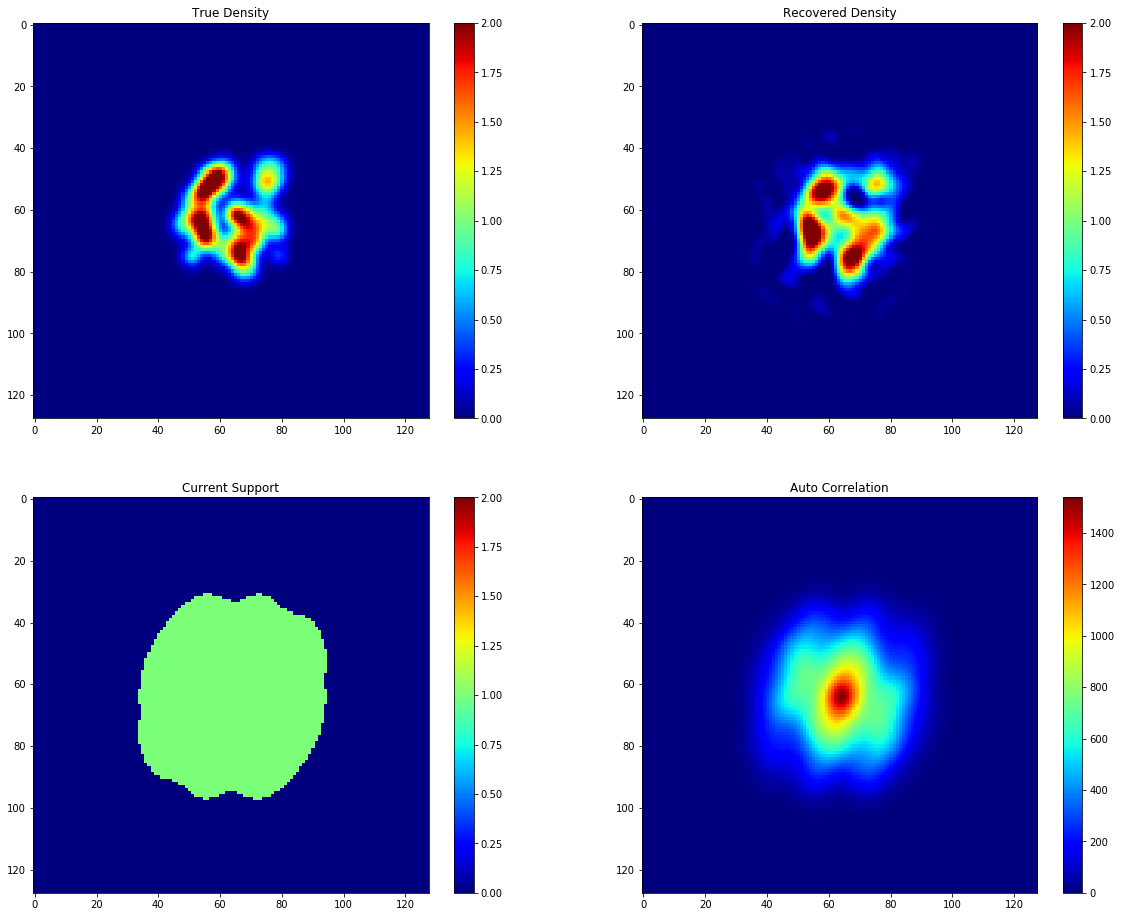

In [13]:
# Set up the canvas anc compare result
recover, _, _ = PhaseTool.util.resolve_trivial_ambiguity(array=np.fft.ifftshift(alter_proj.data_dict['density']), reference_array=sample.density)

print("The relative difference is {}%".format(np.sqrt(np.sum(np.square(recover - sample.density))) / np.sqrt(np.sum(np.square(sample.density)))))

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(16)
fig.set_figwidth(20)

im = axes[0,0].imshow(sample.density, vmax=2, cmap='jet')
fig.colorbar(im, ax=axes[0,0])
axes[0,0].set_title("True Density")

im = axes[0,1].imshow(recover, vmin=0, vmax=2, cmap='jet')
fig.colorbar(im, ax=axes[0,1])
axes[0,1].set_title("Recovered Density")

im = axes[1,0].imshow(np.abs(np.fft.ifftshift(alter_proj.data_dict['support'])), vmax=2, cmap='jet')
fig.colorbar(im, ax=axes[1,0])
axes[1,0].set_title("Current Support")

im = axes[1,1].imshow(sample.autocorrelation,cmap='jet')
fig.colorbar(im, ax=axes[1,1])
axes[1,1].set_title("Auto Correlation")

# Show the canvas
plt.show() 